# Image_Proccess

Abstract:
- single channel: band_avg
- CNN, small net


References:
- https://www.kaggle.com/ivalmian/simple-svd-xgboost-baseline-lb-35
- https://www.kaggle.com/arieltci/a-keras-prototype-0-21174-on-pl

## 1. Preprocess

### Import pkgs

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.metrics import log_loss, accuracy_score
from IPython.display import display

%matplotlib inline

In [34]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2
import cv2

### Run name

In [35]:
project_name = 'SC_Iceberg_Classifier'
step_name = 'Image_Proccess'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

run_name: SC_Iceberg_Classifier_Image_Proccess_20171101_185704


### Basic folders

In [36]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\input
log_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\log
model_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\model
output_path: D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\output


### Unzip files

In [37]:
# with lzma.open("train.json.7z") as f:
#     file_content = f.read()

In [38]:
# Unzip(input_path, os.path.join(input_path, 'sample_submission.csv.7z'))
# Unzip(input_path, os.path.join(input_path, 'test.json.7z'))
# Unzip(input_path, os.path.join(input_path, 'train.json.7z'))

### Load data

In [39]:
sample_submission_path = os.path.join(input_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)
print(sample_submission.shape)
sample_submission.head(2)

(8424, 2)


,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5


In [40]:
%%time
#Load data
data_path = os.path.join(input_path, 'train.json')
test_path = os.path.join(input_path, 'test.json')
pd_data = pd.read_json(data_path)
pd_test = pd.read_json(test_path)
print(pd_data.shape)
print(pd_test.shape)

(1604, 5)
(8424, 4)
Wall time: 42.5 s


In [41]:
#get numpy arrays for train/test data, prob there is a more pythonic approach
band1 = pd_data['band_1'].values
im1 = np.zeros((len(band1),len(band1[0])))
for j in range(len(band1)):
    im1[j,:]=np.asarray(band1[j])
    
band2 = pd_data['band_2'].values
im2 = np.zeros((len(band2),len(band2[0])))
for j in range(len(band2)):
    im2[j,:]=np.asarray(band2[j])
    
#get numpy array for test data
band1test = pd_test['band_1'].values
im1test = np.zeros((len(band1test),len(band1test[0])))
for j in range(len(band1test)):
    im1test[j,:]=np.asarray(band1test[j])
    
band2test = pd_test['band_2'].values
im2test = np.zeros((len(band2test),len(band2test[0])))
for j in range(len(band2test)):
    im2test[j,:]=np.asarray(band2test[j])

In [42]:
print(pd_data['id'].values.shape)
print(pd_data['band_1'].values.shape)
print(pd_data['band_2'].values.shape)
print(pd_data['inc_angle'].values.shape)
print(pd_data['is_iceberg'].values.shape)

(1604,)
(1604,)
(1604,)
(1604,)
(1604,)


In [43]:
id_data = pd_data['id'].as_matrix()
id_test = pd_test['id'].as_matrix()
print(id_data.shape)
print(id_test.shape)

(1604,)
(8424,)


In [44]:
inc_angle_data = pd_data['inc_angle'].replace('na', 0).astype(float).fillna(0.0)
inc_angle_test = pd_test['inc_angle'].replace('na', 0).astype(float).fillna(0.0)
print(inc_angle_data.shape)
print(inc_angle_test.shape)

(1604,)
(8424,)


In [45]:
y_data = pd_data['is_iceberg']
print(y_data.shape)

(1604,)


In [46]:
band1_data = im1.reshape(-1, 75,75)
band2_data = im2.reshape(-1, 75,75)

band1_test = im1test.reshape(-1, 75,75)
band2_test = im2test.reshape(-1, 75,75)

print(band1_data.shape)
print(band2_data.shape)
print(band1_test.shape)
print(band2_test.shape)

(1604, 75, 75)
(1604, 75, 75)
(8424, 75, 75)
(8424, 75, 75)


In [47]:
band_avg_data = (band1_data + band2_data)/2
print(band_avg_data.shape)
band_avg_test = (band1_test + band2_test)/2
print(band_avg_test.shape)

(1604, 75, 75)
(8424, 75, 75)


(75, 75)


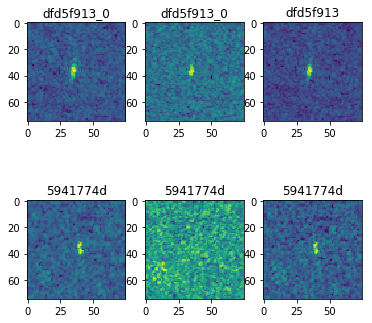

In [48]:
# Preview images
print(band1_data[0].shape)
fig, ax = plt.subplots(2, 3, figsize=(6,6))
ax[0, 0].imshow(band1_data[0].reshape(75, 75))
ax[0, 0].set_title(id_data[0] + '_' + str(y_data[0]))
ax[0, 1].imshow(band2_data[0].reshape(75, 75))
ax[0, 1].set_title(id_data[0] + '_' + str(y_data[1]))
ax[0, 2].imshow(band_avg_data[0].reshape(75, 75))
ax[0, 2].set_title(id_data[0])

ax[1, 0].imshow(band1_test[0].reshape(75, 75))
ax[1, 0].set_title(id_test[0])
ax[1, 1].imshow(band2_test[0].reshape(75, 75))
ax[1, 1].set_title(id_test[0])
ax[1, 2].imshow(band_avg_test[0].reshape(75, 75))
ax[1, 2].set_title(id_test[0])

### Binarizer

二值化的效果不够理想

(75, 75)
Binarizer(copy=True, threshold=-20.655830959107355)
Binarizer(copy=True, threshold=-26.320701804264864)
Binarizer(copy=True, threshold=-23.488266381686106)


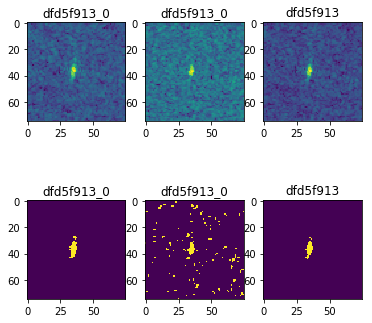

In [49]:
# Preview images
index = 0
print(band1_data[0].shape)
fig, ax = plt.subplots(2, 3, figsize=(6,6))
ax[0, 0].imshow(band1_data[index].reshape(75, 75))
ax[0, 0].set_title(id_data[index] + '_' + str(y_data[index]))
ax[0, 1].imshow(band2_data[index].reshape(75, 75))
ax[0, 1].set_title(id_data[index] + '_' + str(y_data[index]))
ax[0, 2].imshow(band_avg_data[index].reshape(75, 75))
ax[0, 2].set_title(id_data[index])

binarizer1 = Binarizer(copy=True, threshold=im1.mean()).fit(im1)
print(binarizer1)
band1_data_bin = binarizer1.transform(im1)

binarizer2 = Binarizer(copy=True, threshold=im2.mean()).fit(im2)
print(binarizer2)
band2_data_bin = binarizer2.transform(im2)

im_avg = (im1 + im2)/2
binarizer_avg = Binarizer(copy=True, threshold=im_avg.mean()).fit(im_avg)
print(binarizer_avg)
band_data_avg_bin = binarizer_avg.transform(im_avg)

ax[1, 0].imshow(band1_data_bin[index].reshape(75, 75))
ax[1, 0].set_title(id_data[index] + '_' + str(y_data[index]))
ax[1, 1].imshow(band2_data_bin[index].reshape(75, 75))
ax[1, 1].set_title(id_data[index] + '_' + str(y_data[index]))
ax[1, 2].imshow(band_data_avg_bin[index].reshape(75, 75))
ax[1, 2].set_title(id_data[index])

(75, 75)
Binarizer(copy=True, threshold=-22.44550520353285)
Binarizer(copy=True, threshold=-24.693380698518308)
Binarizer(copy=True, threshold=-23.488266381686106)


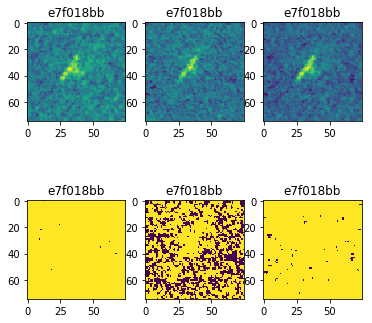

In [50]:
# Preview images
index = 3
print(band1_test[0].shape)
fig, ax = plt.subplots(2, 3, figsize=(6,6))
ax[0, 0].imshow(band1_test[index].reshape(75, 75))
ax[0, 0].set_title(id_test[index])
ax[0, 1].imshow(band2_test[index].reshape(75, 75))
ax[0, 1].set_title(id_test[index])
ax[0, 2].imshow(band_avg_test[index].reshape(75, 75))
ax[0, 2].set_title(id_test[index])

binarizer1 = Binarizer(copy=True, threshold=im1test.mean()).fit(im1test)
print(binarizer1)
band1_test_bin = binarizer1.transform(im1test)

binarizer2 = Binarizer(copy=True, threshold=im2test.mean()).fit(im2test)
print(binarizer2)
band2_test_bin = binarizer2.transform(im2test)

im_test_avg = (im1test + im2test)/2
binarizer_avg = Binarizer(copy=True, threshold=im_avg.mean()).fit(im_test_avg)
print(binarizer_avg)
band_test_avg_bin = binarizer_avg.transform(im_test_avg)

ax[1, 0].imshow(band1_test_bin[index].reshape(75, 75))
ax[1, 0].set_title(id_test[index])
ax[1, 1].imshow(band2_test_bin[index].reshape(75, 75))
ax[1, 1].set_title(id_test[index])
ax[1, 2].imshow(band_test_avg_bin[index].reshape(75, 75))
ax[1, 2].set_title(id_test[index])

(75, 75)
(75, 75)
MinMaxScaler(copy=True, feature_range=(0, 128))
(75, 75)


error: C:\projects\opencv-python\opencv\modules\imgproc\src\smooth.cpp:4377: error: (-210) Bilateral filtering is only implemented for 8u and 32f images in function cv::bilateralFilter


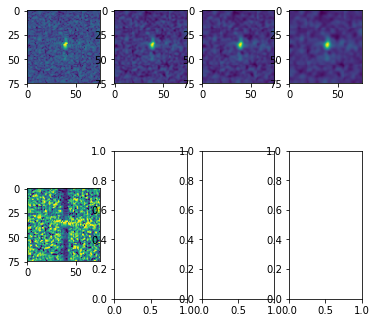

In [51]:
# cv2.imshow("Gaussian",band1_data[index].reshape(75, 75))
fig, ax = plt.subplots(2, 4, figsize=(6,6))

img = band1_data[index].reshape(75, 75)
print(img.shape)
ax[0, 0].imshow(img)
blur = cv2.GaussianBlur(img,(3,3), 0)
ax[0, 1].imshow(blur)
blur = cv2.GaussianBlur(img,(5,5), 0)
ax[0, 2].imshow(blur)
blur = cv2.GaussianBlur(img,(7,7), 0)
ax[0, 3].imshow(blur)

scaler = MinMaxScaler(feature_range = (0, 128))
print(img.shape)
print(scaler.fit(img))
img = scaler.transform(img)
img = img.astype(int)

print(img.shape)
ax[1, 0].imshow(img)
blur = cv2.bilateralFilter(img,3,5,5)
ax[1, 1].imshow(blur)
blur = cv2.bilateralFilter(img,9,5,5)
ax[1, 2].imshow(blur)
blur = cv2.bilateralFilter(img,9,5,5)
ax[1, 3].imshow(blur)

In [29]:
print(img[0].shape)

(75,)


In [ ]:
x_data = np.concatenate([band1_data[:, :, :, np.newaxis],
                         band2_data[:, :, :, np.newaxis],
                         band_avg_data[:, :, :, np.newaxis]], axis=-1)
print(x_data.shape)
x_test = np.concatenate([band1_test[:, :, :, np.newaxis],
                         band2_test[:, :, :, np.newaxis],
                         band_avg_test[:, :, :, np.newaxis]], axis=-1)
print(x_test.shape)

In [18]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.15, shuffle=True, random_state=31)
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(1363, 75, 75, 3)
(241, 75, 75, 3)
(1363,)
(241,)


## 2. Build model

In [19]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [20]:
def build_model():
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu',
                     input_shape = (75, 75, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 256, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 1, activation = 'sigmoid'))

    model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [21]:
model1 = build_model()

In [22]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
saveModel(model1, 'saveModel_test')

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:D:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\log\SC_Iceberg_Classifier_CNN_3channel_20171101_151807


In [ ]:
hist = model1.fit(x_train, y_train, 
                 batch_size = 8, 
                 verbose= 1,
                 epochs = 50, #1 for ETA, 0 for silent
                 validation_data=(x_val, y_val),
                 callbacks=[annealer, tensorBoard])

Train on 1363 samples, validate on 241 samples
Epoch 1/50
1363/1363 [==============================] - 82s - loss: 6.0646 - acc: 0.5789 - val_loss: 8.3573 - val_acc: 0.4689
Epoch 2/50
1360/1363 [============================>.] - ETA: 0s - loss: 7.4523 - acc: 0.5309

In [ ]:
final_loss, final_acc = model1.evaluate(x_val, y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

In [ ]:
val_prob1 = model1.predict(x_val)

# print('Val log_loss: {}'.format(log_loss(y_val, val_prob1)))
val_prob1_limit = np.clip(val_prob1, 0.00005, 0.99995)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

val_prob1_limit = np.clip(val_prob1_limit, 0.05, 0.95)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

In [ ]:
final_acc_str = str(int(loss*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

In [ ]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

In [ ]:
plt.plot(histories['loss'], color='b')
plt.plot(histories['val_loss'], color='r')
plt.show()
plt.plot(histories['acc'], color='b')
plt.plot(histories['val_acc'], color='r')
plt.show()

In [ ]:
saveModel(model1, run_name_acc)

## 3. Predict

In [ ]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, run_name_acc + '.csv')
print(pred_file)

In [ ]:
test_prob = model1.predict(x_test)
print(test_prob.shape)
print(test_prob[0:2])
test_prob = np.clip(test_prob, 0.05, 0.95)
print(test_prob.shape)
print(test_prob[0:2])

In [ ]:
sample_submission['is_iceberg'] = test_prob
print(sample_submission[0:2])
print(sample_submission.shape)
sample_submission.to_csv(pred_file, index=False)

In [ ]:
print(run_name_acc)
print('Done!')